# Summaries
the idea is to use summaries for each teime series,
pros:
- less features
- easy to compute

cons:
- breaking the time dependency

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

In [3]:
df_train = pd.read_csv('data\\train.csv')
# df_train.to_parquet('train.parquet')
# df_train = pd.read_parquet('train.parquet')
df_ts = df_train.iloc[:,5:] # timeseries features only
df_train['y_s'] = df_train.y > 1 # simplified y: label 0 for 1 and 1 for 2,3 



In [35]:
import scipy.stats as sp

summaries = {
    'max': np.max,
    'min': np.min,
    'mean': np.mean,
    # 'q01': lambda x: np.quantile(x, q=0.01),
    # 'q05': lambda x: np.quantile(x, q=0.05),
    # 'q25': lambda x: np.quantile(x, q=0.25),
    'median': np.median,
    # 'q75': lambda x: np.quantile(x, q=0.75),
    # 'q95': lambda x: np.quantile(x, q=0.95),
    # 'q99': lambda x: np.quantile(x, q=0.99),
    # 'sd' : np.std,
    'var': np.var,
    # 'kurtosis': sp.kurtosis,
    # 'trim_mean': lambda x: sp.trim_mean(x, 0.25),
}

from util import apply_summaries
X = apply_summaries(df_ts, summaries)
X


,max_E1A,max_E1H,max_E1P,max_E1V,max_E2A,max_E2H,max_E2P,max_E2V,max_E3A,max_E3H,...,var_E4P,var_E4V,var_M1A,var_M1H,var_M1P,var_M1V,var_M2A,var_M2H,var_M2P,var_M2V
0,3.106584,12.067687,19.177058,2.904495,2.064329,7.027072,6.340742,2.982987,3.890517,14.949150,...,1.576292,1.081744,0.002518,0.028723,0.007773,0.004650,0.033599,0.083784,0.050929,0.010923
1,1.973324,3.334162,3.230021,2.075948,2.325271,3.196759,3.119100,2.203837,2.168119,4.257831,...,0.463476,2.344031,0.078869,0.154474,0.031542,0.081549,0.083529,0.078944,0.022594,0.037661
2,4.905155,3.816043,4.624890,1.912259,3.906155,4.914904,6.291021,3.556789,2.485419,5.553386,...,1.348357,0.572394,0.129907,0.206942,0.022583,0.045760,0.146828,0.073277,0.013144,0.040477
3,4.146159,12.211521,20.694593,1.946000,2.528676,12.353929,17.187908,1.648643,3.365520,19.111603,...,4.368171,0.511842,0.006673,0.017267,0.000977,0.005699,0.011252,0.084894,0.023829,0.016561
4,2.507720,6.752539,6.668999,3.012293,2.204402,7.998847,8.025621,2.356230,2.283782,10.433940,...,1.548678,0.347480,0.004256,0.015543,0.001484,0.010379,0.005883,0.020817,0.003872,0.007045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,2.627815,10.701584,12.654741,2.283455,2.531638,7.849816,6.931436,2.794771,2.605332,11.994953,...,0.604325,0.369244,0.009869,0.027505,0.006330,0.012213,0.005666,0.059624,0.028356,0.013315
659,2.733922,4.979573,8.429594,3.103308,1.884466,7.571239,13.081043,1.217670,2.633123,6.707066,...,1.045160,0.463721,0.035844,0.009648,0.002651,0.066349,0.037449,0.024181,0.011093,0.022227
660,4.631380,12.068901,14.897799,4.111245,2.937032,8.865655,13.798335,2.973656,10.616217,12.786204,...,1.872799,0.926809,0.021511,0.011962,0.002565,0.017994,0.033627,0.063842,0.035000,0.047155
661,2.340140,3.257143,9.396940,3.182236,4.438345,5.194028,5.873247,3.869224,3.320506,10.530150,...,0.574633,0.806986,0.081197,0.102883,0.008709,0.022697,0.151970,0.112806,0.039846,0.038374


C:\Users\laura\AppData\Local\Temp\ipykernel_13532\3433851866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['y'] = df_train.y


C:\Users\laura\AppData\Local\Temp\ipykernel_13532\1415578101.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['y'] = df_train.y
C:\Users\laura\AppData\Local\Temp\ipykernel_13532\1415578101.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['y'] = df_train.y
C:\Users\laura\AppData\Local\Temp\ipykernel_13532\1415578101.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

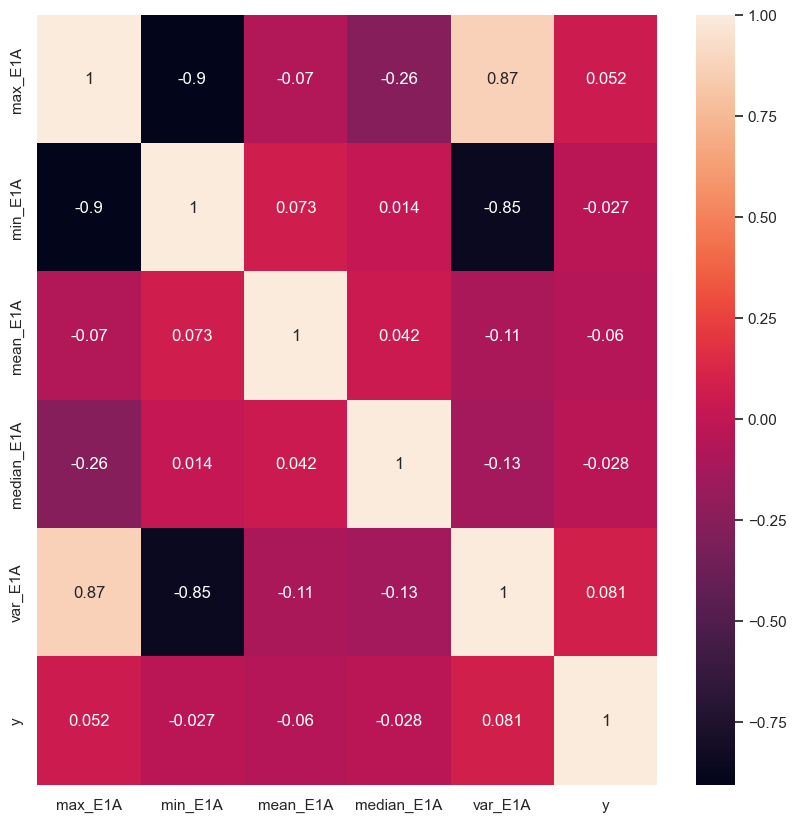

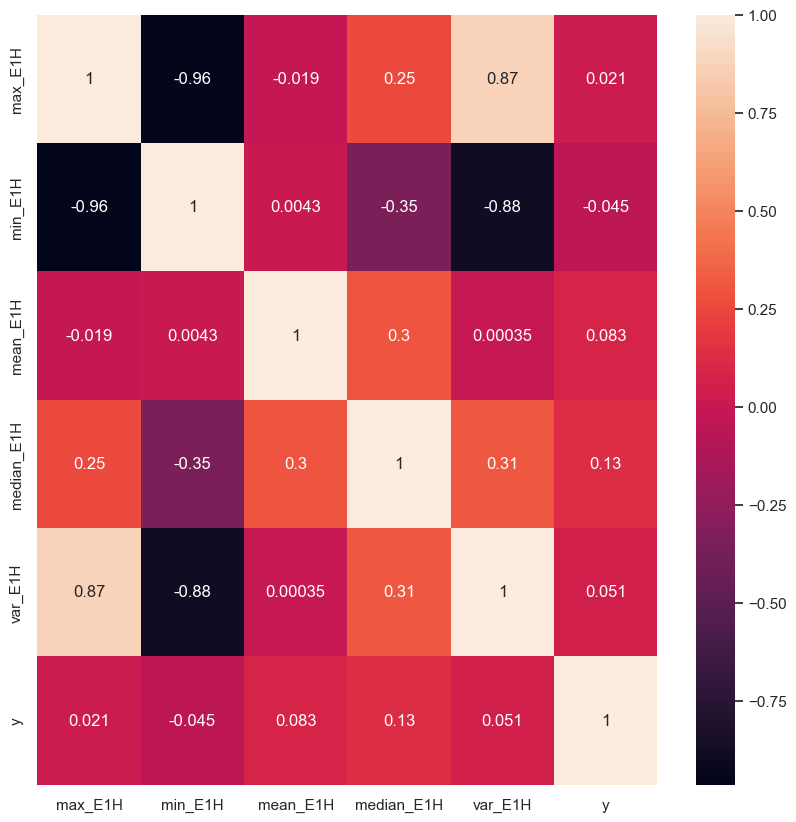

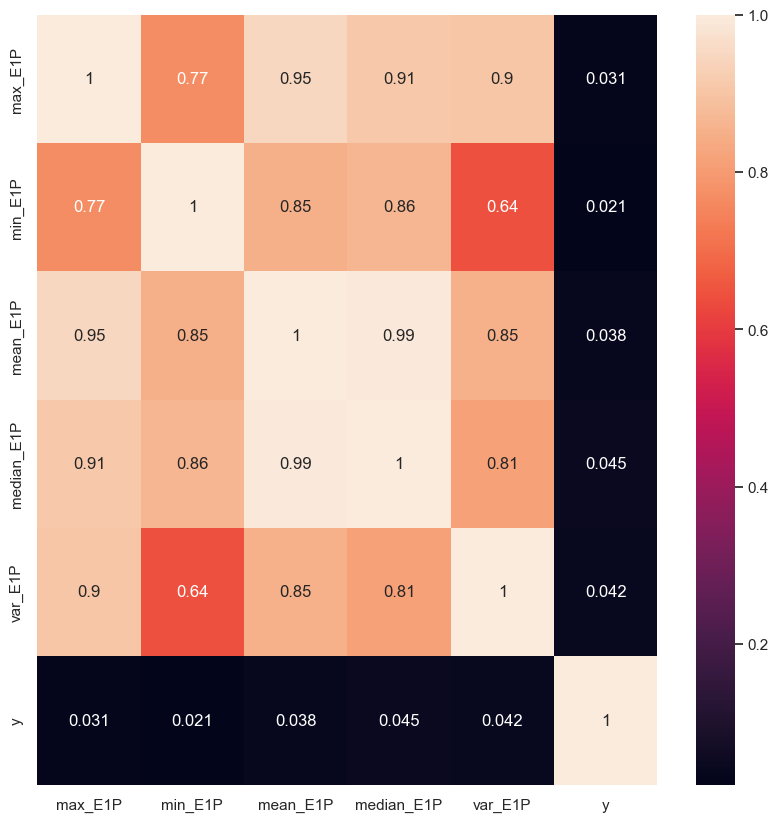

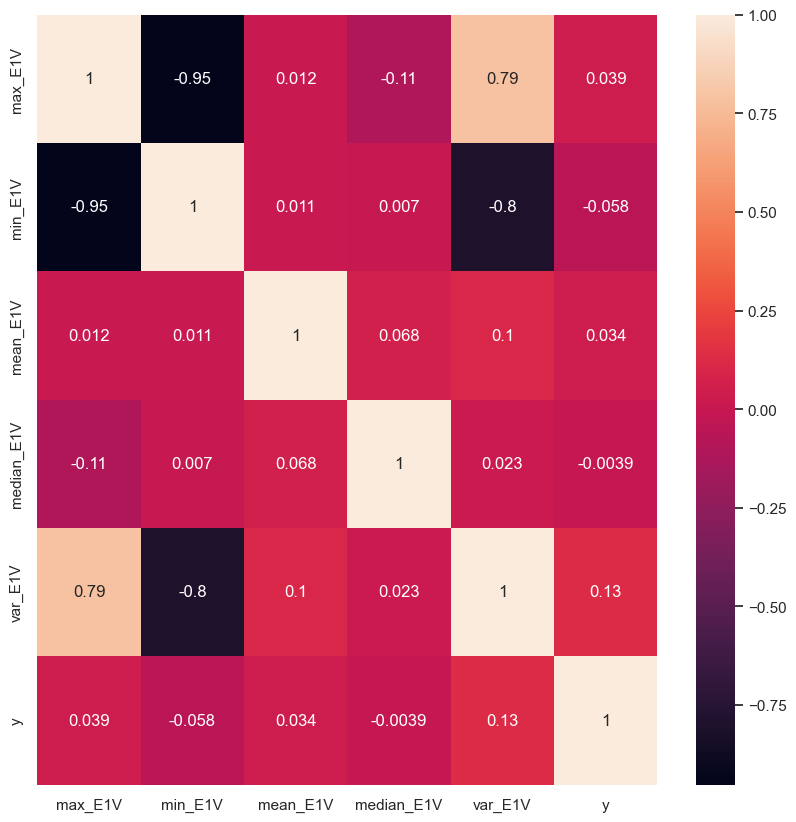

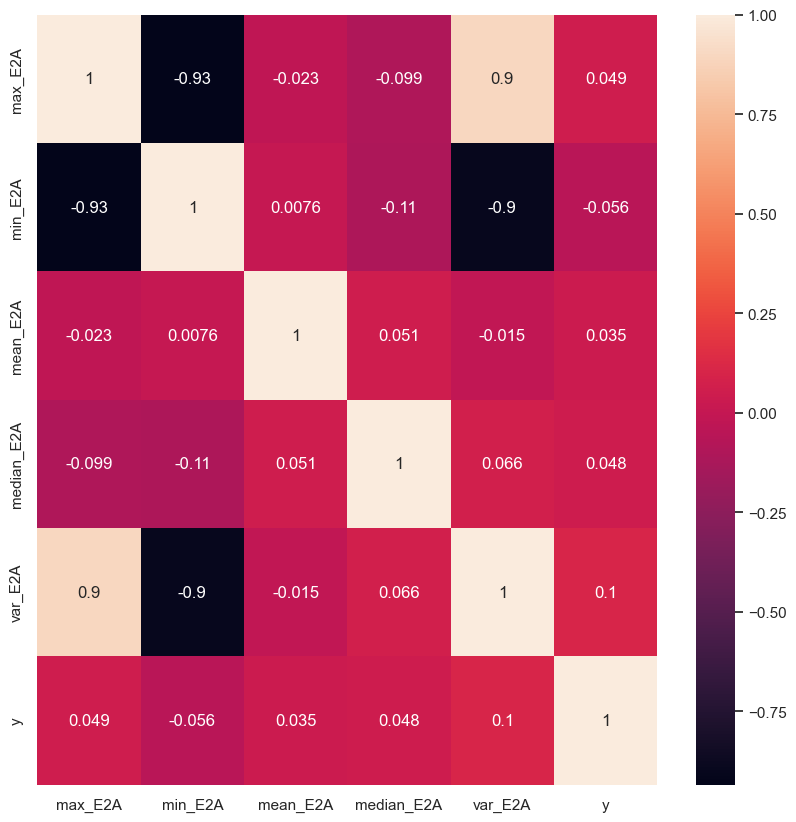

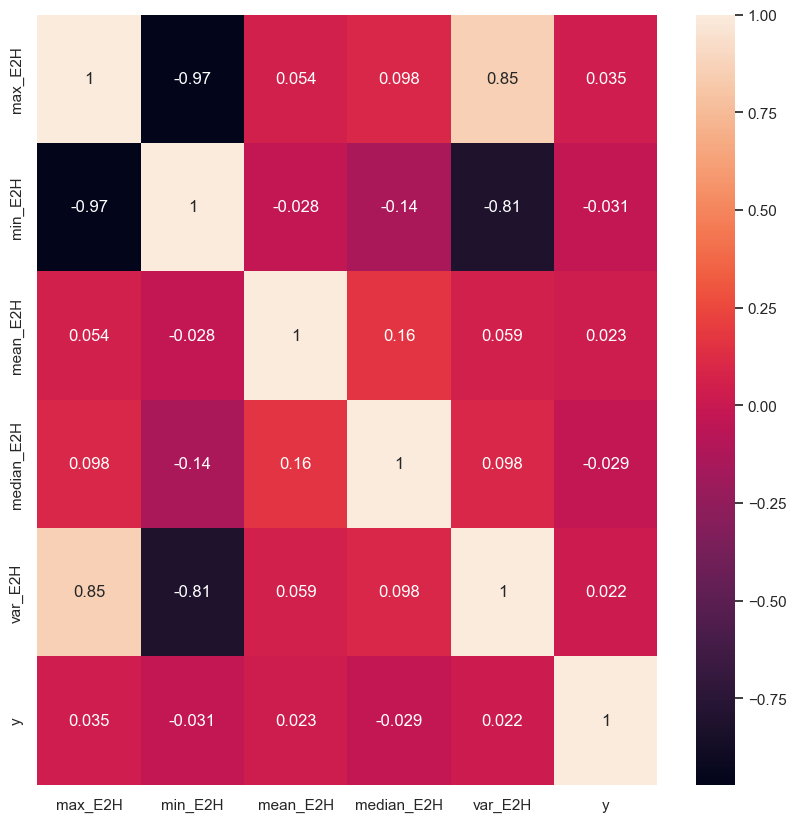

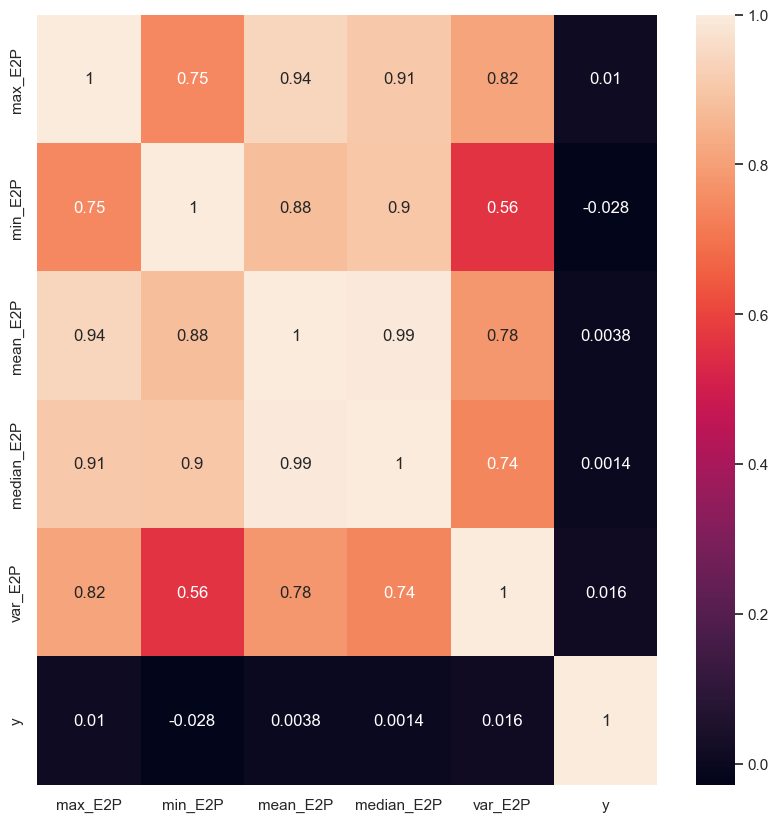

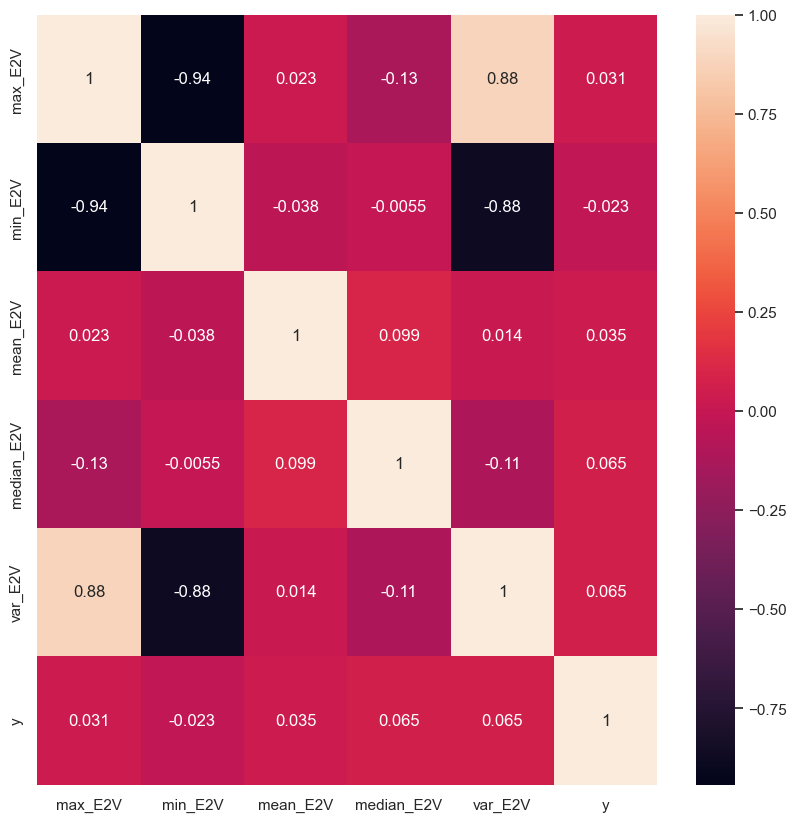

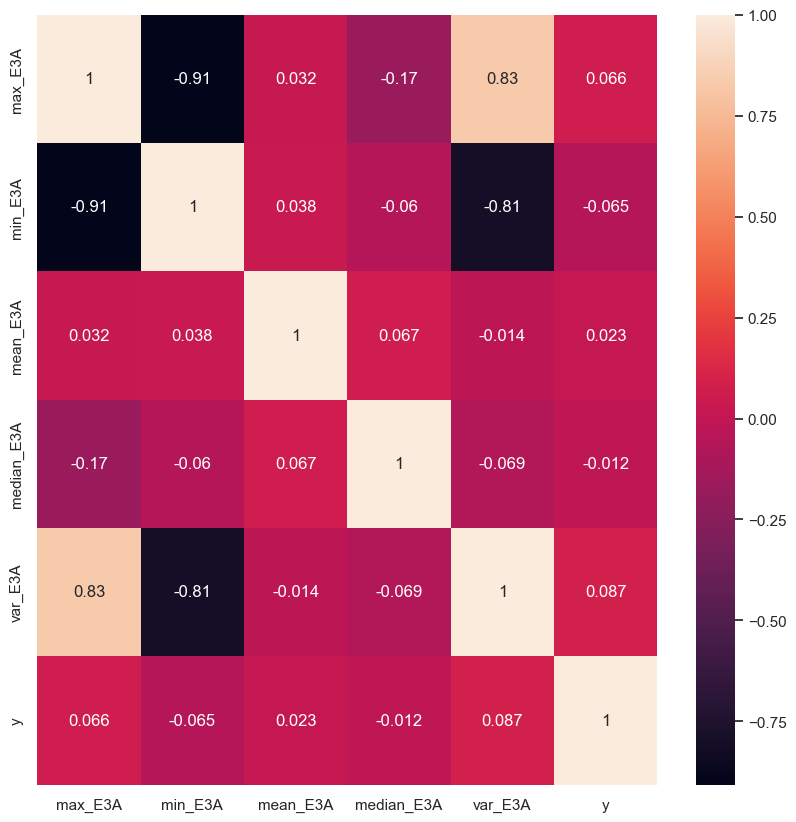

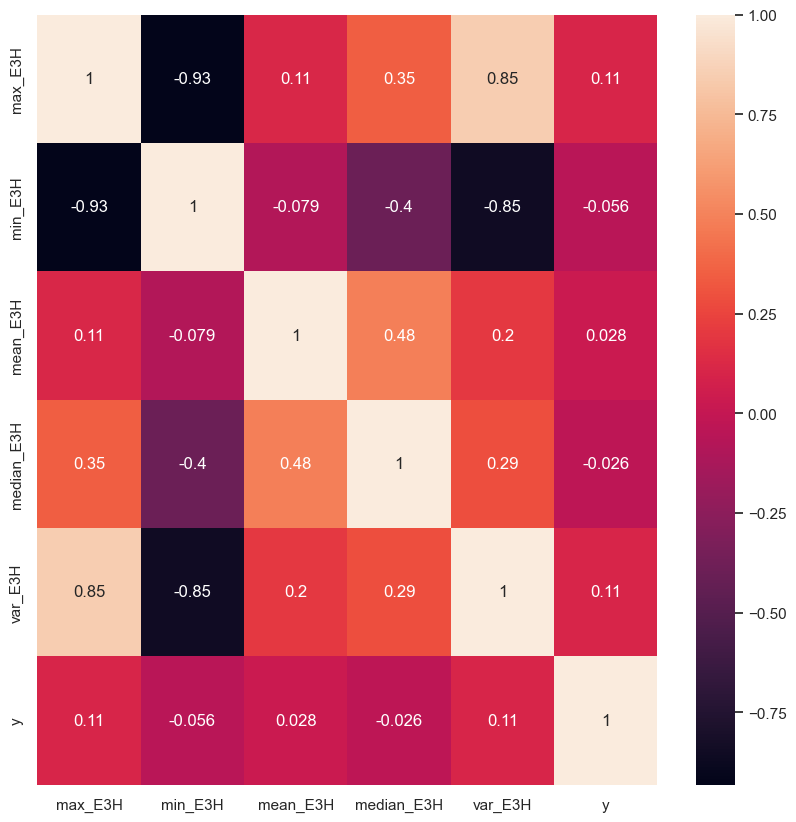

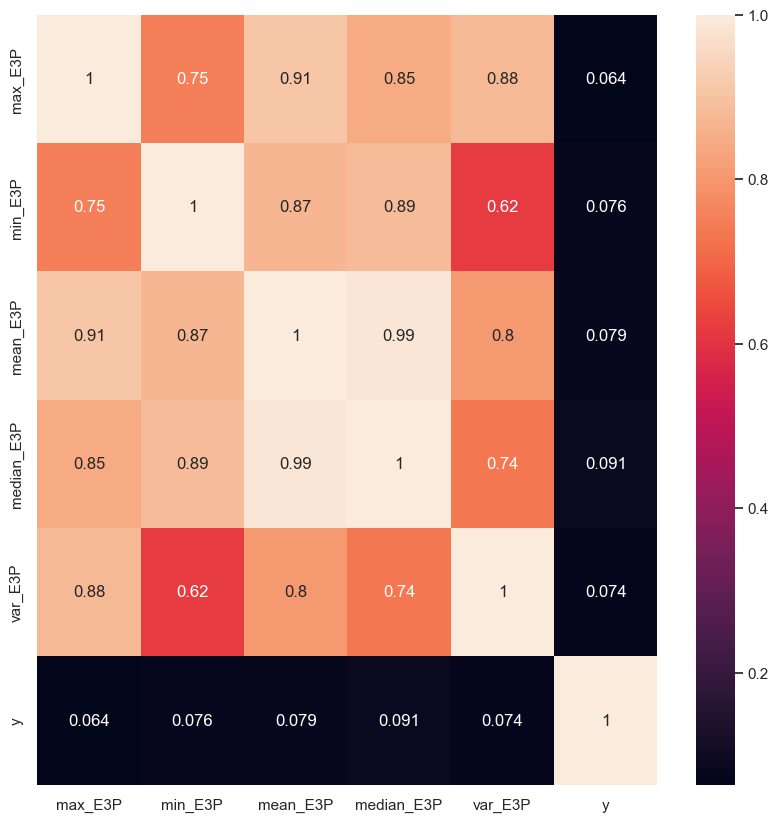

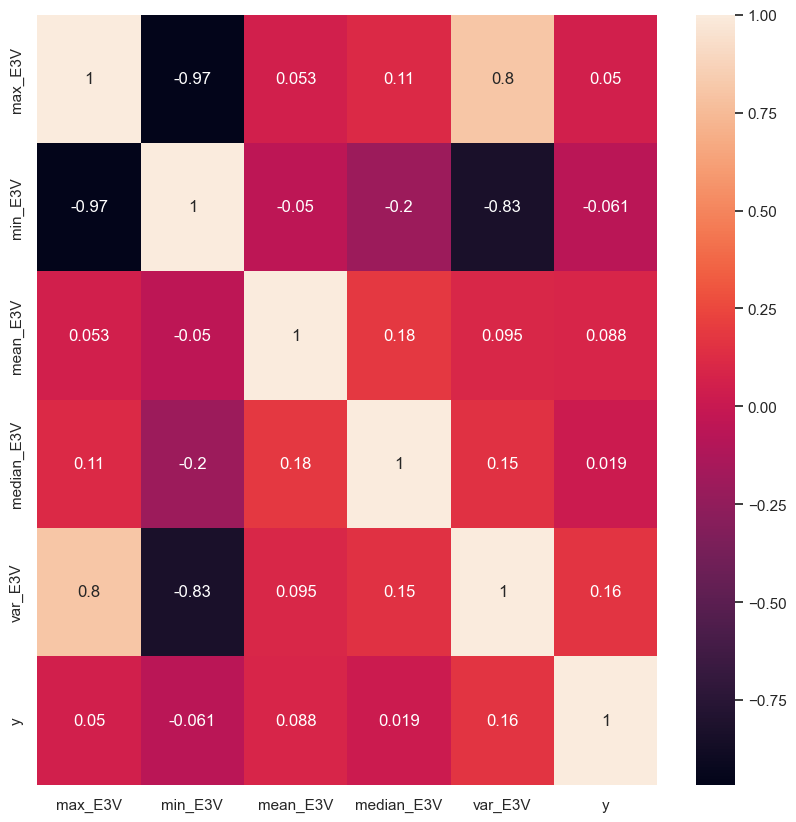

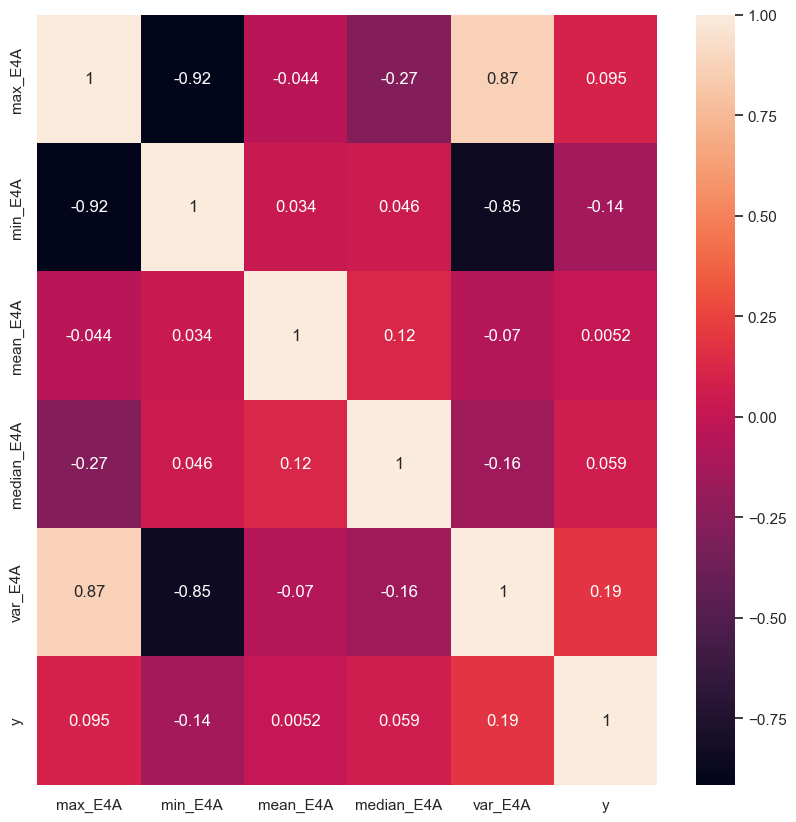

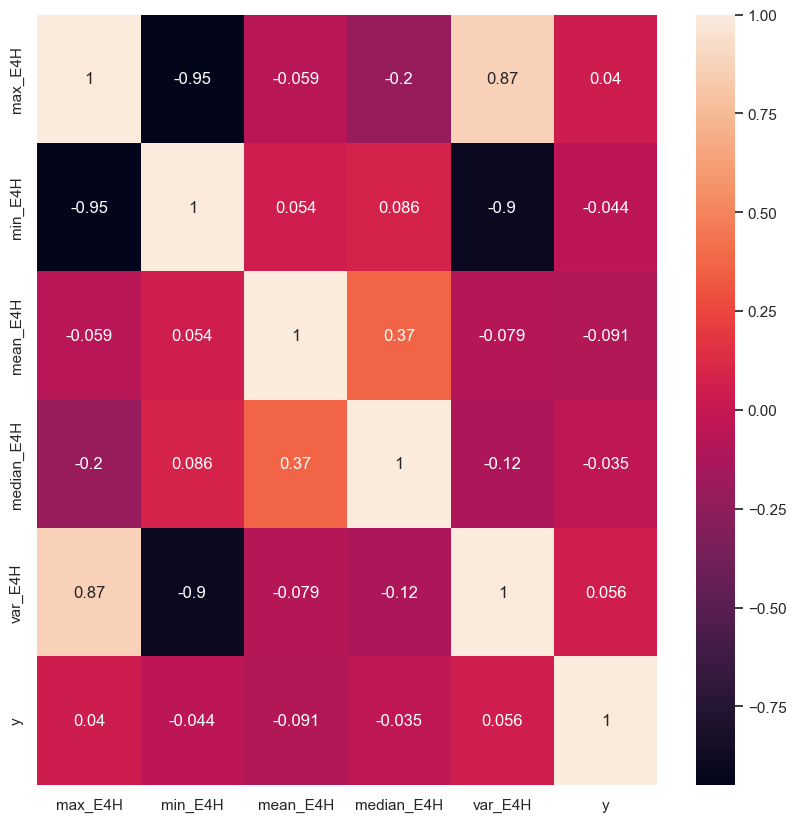

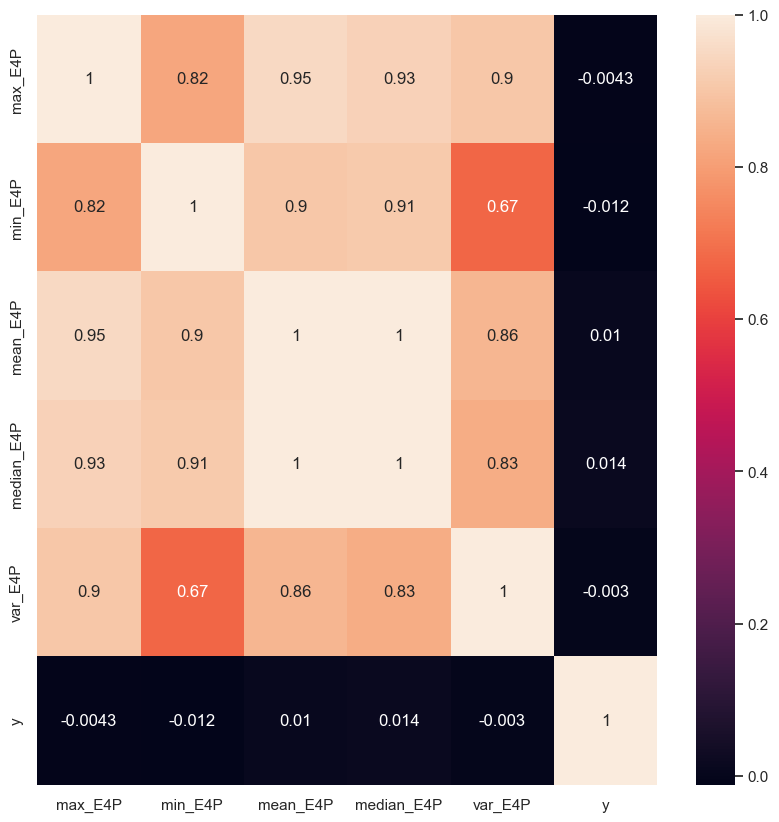

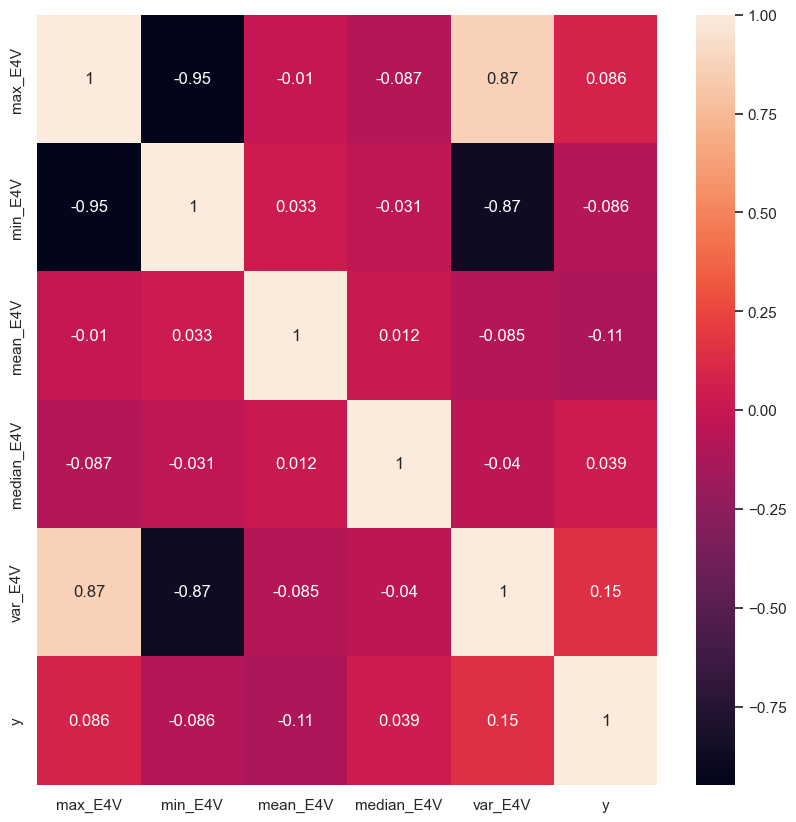

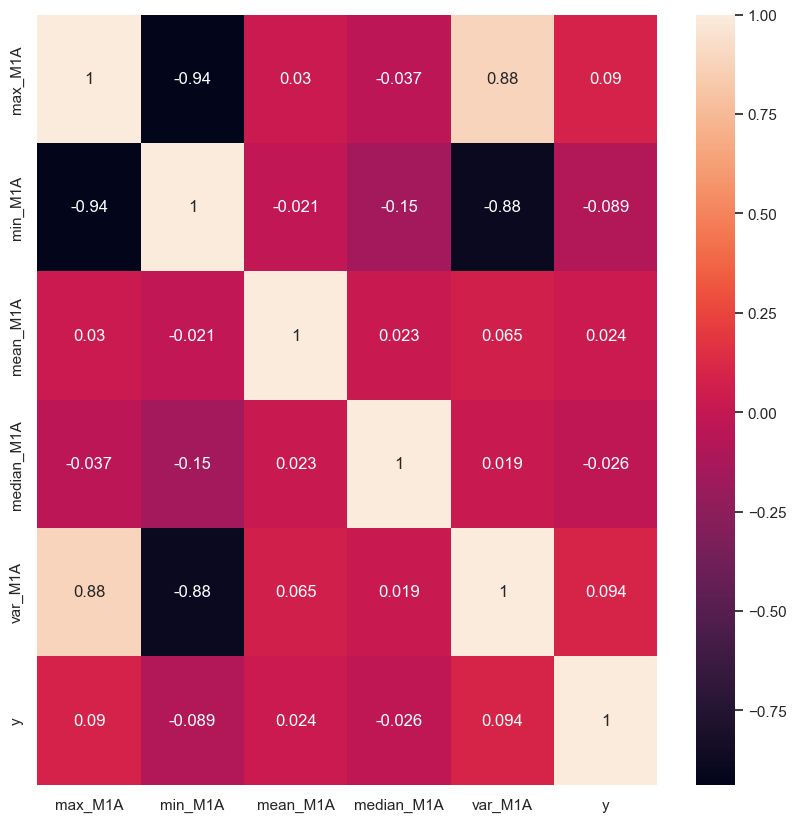

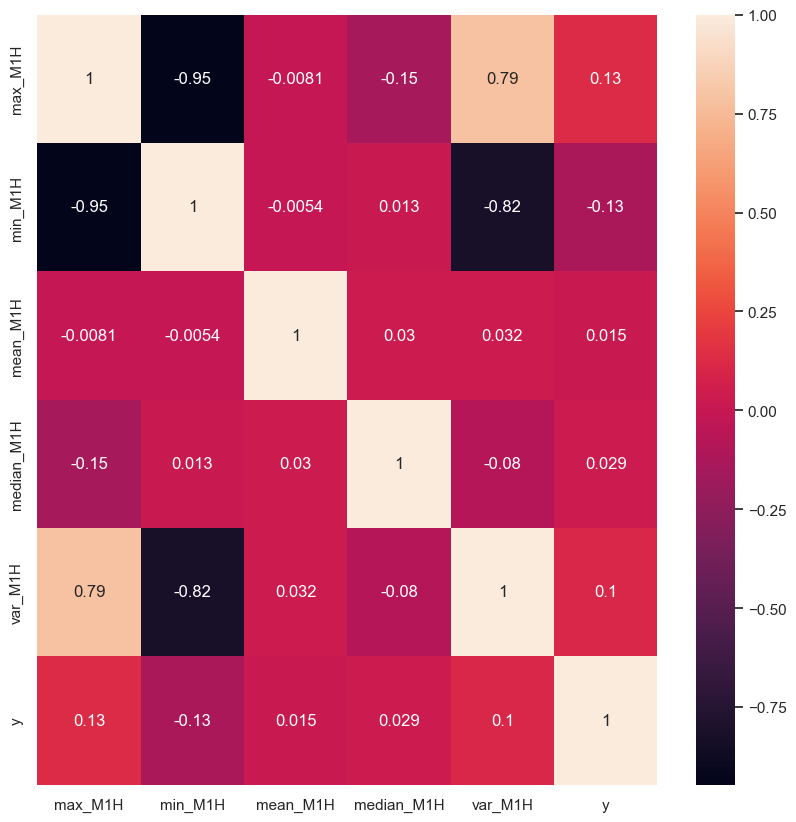

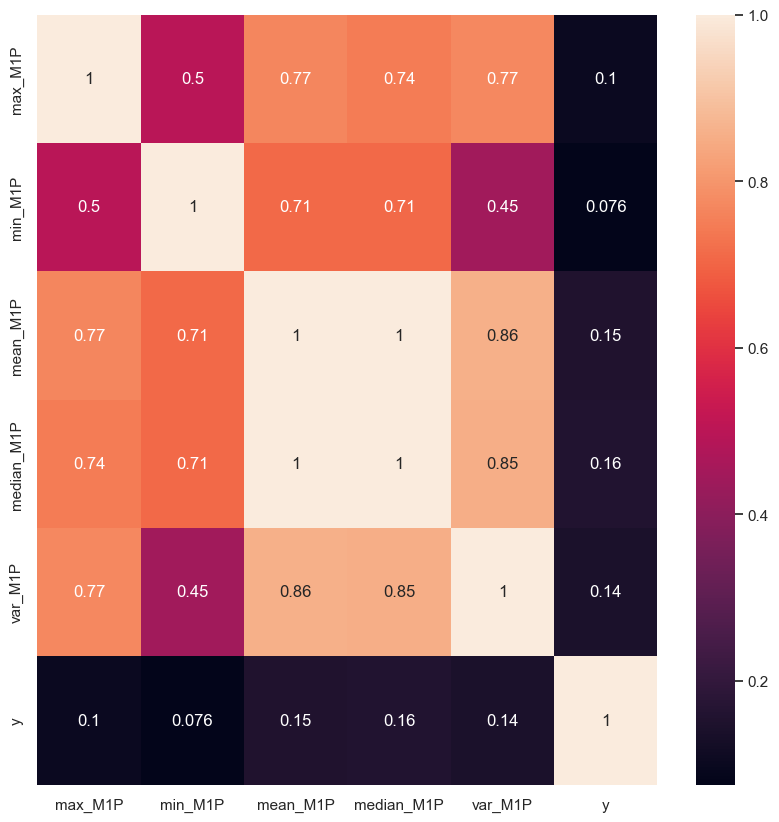

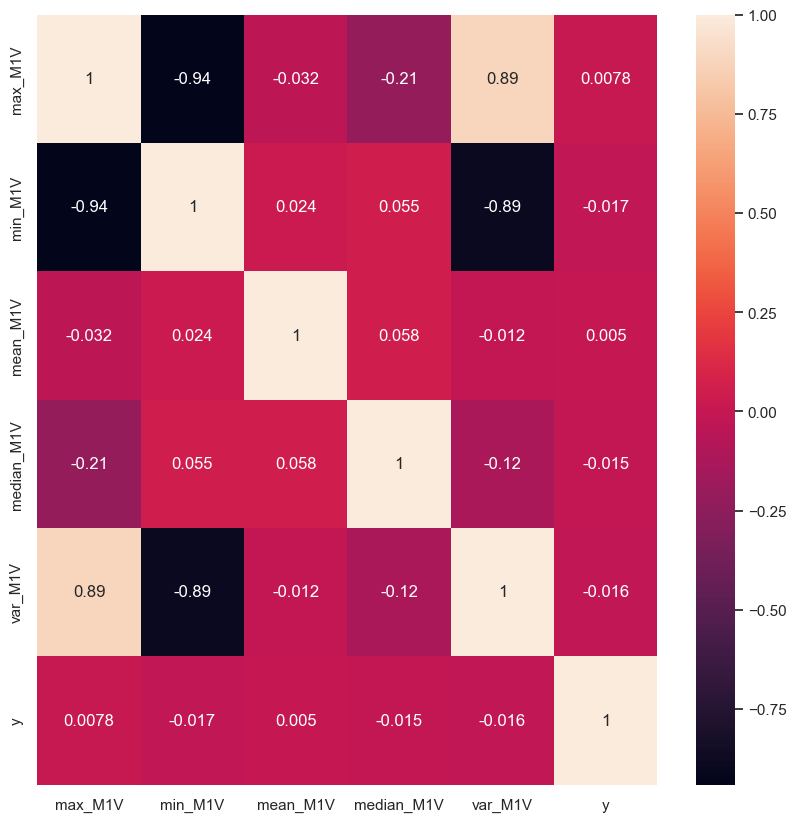

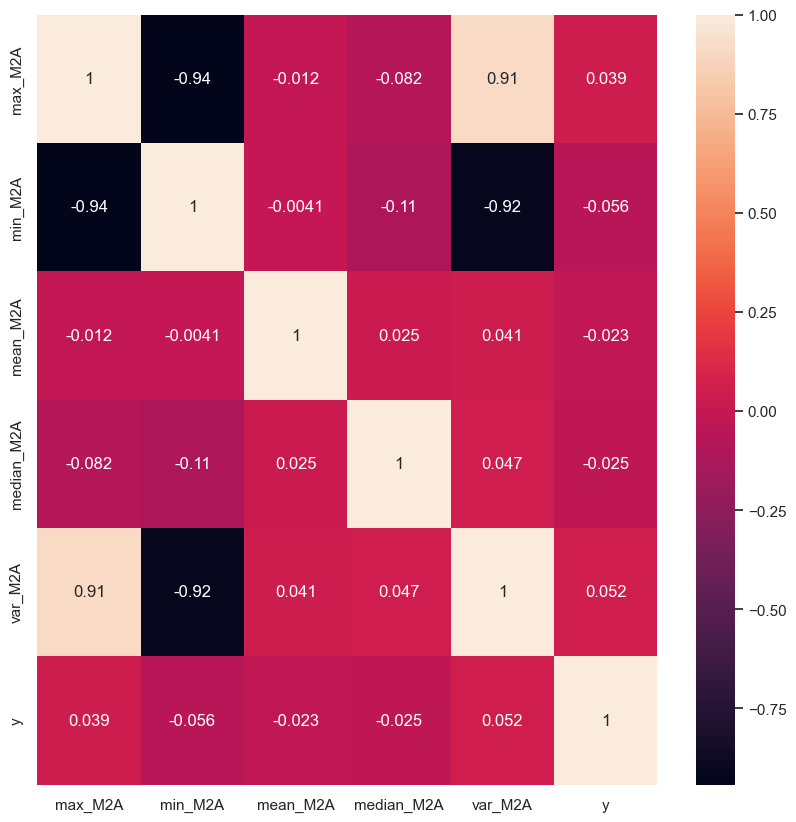

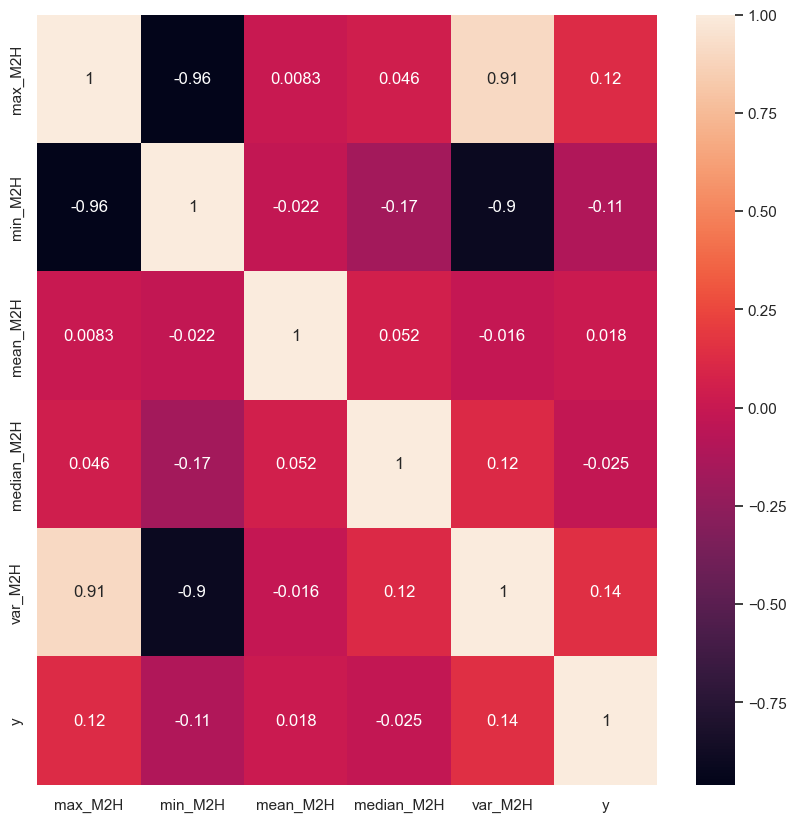

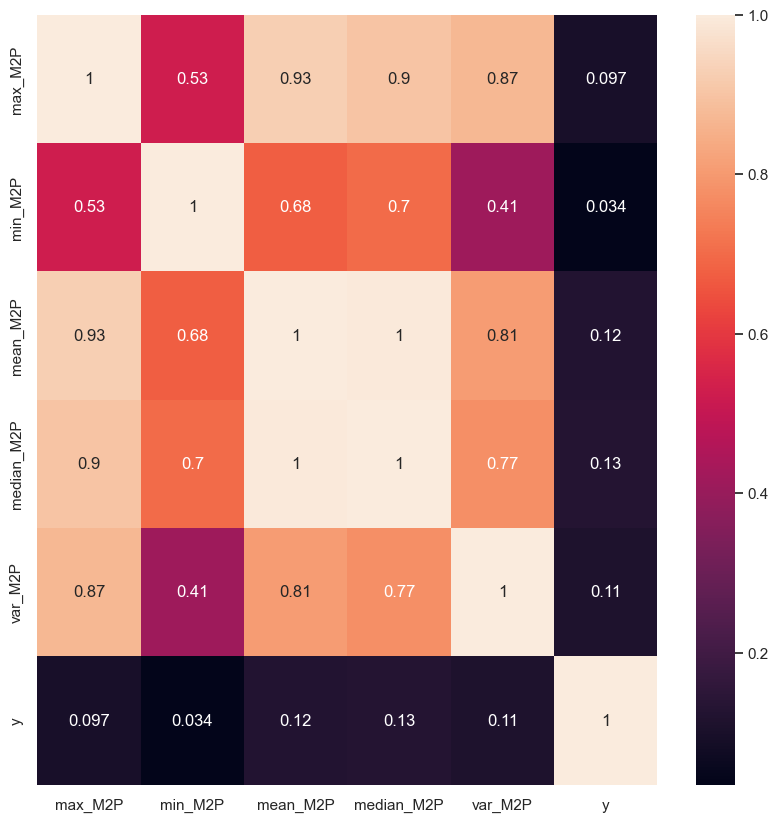

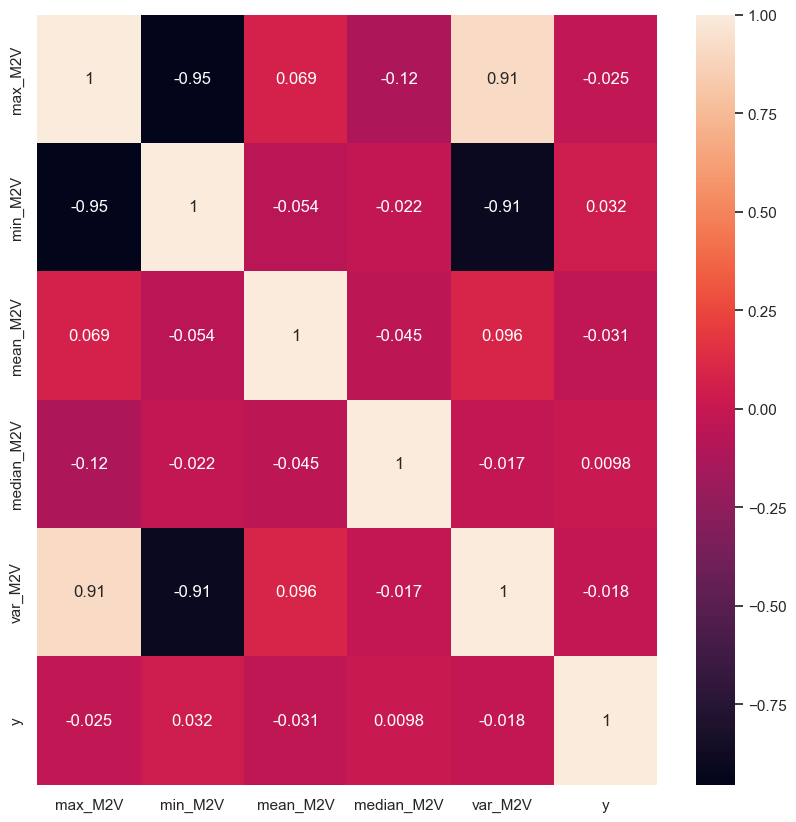

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in range(24):
    d = X.iloc[:,i::24]
    d['y'] = df_train.y

    plt.figure(figsize=(10,10))
    sns.heatmap(d.corr(), annot=True)


## Model fit

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(X, df_train.y_s, test_size=0.3, stratify=df_train.y_s)
model = SVC(C=2, class_weight='balanced')
model.fit(x_train,y_train)

SVC(C=2, class_weight='balanced')

(array([[122,  64],
        [  7,   6]], dtype=int64),
 0.5587262200165426)

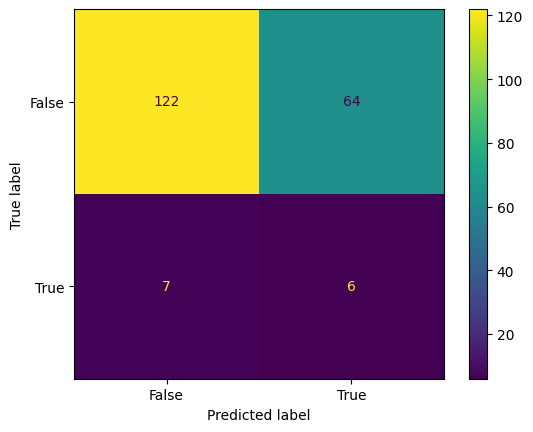

In [24]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay

y_hat = model.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)

confusion_matrix(y_test,y_hat),balanced_accuracy_score(y_test, y_hat)

## Cross-validation

In [37]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
model = SVC(class_weight='balanced')
params = {'C' : np.linspace(0.1,3,40),
          'kernel':['poly','rbf','linear']}
skf = StratifiedKFold(n_splits=4)

In [54]:
cv = GridSearchCV(
    model, 
    param_grid=params, 
    scoring='balanced_accuracy', 
    n_jobs=-1, 
    cv=skf.split(X, df_train.y_s)
)
cv.fit(X,df_train.y_s)

cv.best_params_, cv.best_score_

({'C': 0.17435897435897435, 'kernel': 'linear'}, 0.6693181818181818)

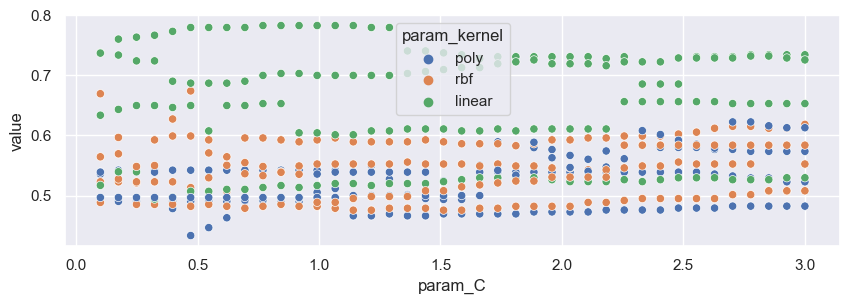

In [55]:
from util import plot_cv_results
plot_cv_results(cv, 'param_C', 'param_kernel')

In [57]:
y_hat = cv.predict(X)+1
confusion_matrix(df_train.y, y_hat),balanced_accuracy_score(df_train.y, y_hat)

(array([[485, 135,   0],
        [  0,  39,   0],
        [  0,   4,   0]], dtype=int64),
 0.5940860215053764)

# Submission

In [59]:
model_final = cv
# model_final.fit(X, df_train.y)

In [60]:
df_sub = pd.read_csv('data\\test.csv')
X_sub = apply_summaries(df_sub.iloc[:,4:], funcs=summaries)

In [62]:
from datetime import datetime
y_sub = model_final.predict(X_sub)
submission_df = pd.DataFrame(y_sub,columns=['y'])
submission_df['id'] = df_sub.id
submission_df.set_index('id', inplace=True)
submission_df.y = submission_df.y + 1
submission_df.to_csv(f'data\\submissions\\summary_{datetime.now().strftime("%H.%M_%d")}.csv')